In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from scipy.signal import savgol_filter
from sklearn.neighbors import KNeighborsRegressor

### Find the transformation to remove the y vibration, and smooth it some

26.877919394000003


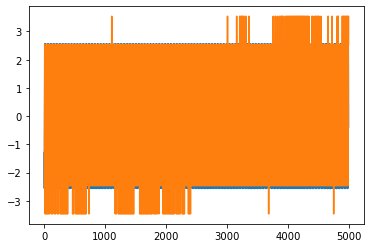

In [2]:
start=timeit.default_timer()

video=cv2.VideoCapture('vid_2022-05-26_10-37-49.mp4')
ret,frame = video.read()
frame_height,frame_width=frame.shape[:2]

n_frames=4999
transforms_y = np.zeros((n_frames-1), np.float32) 

for i in range(n_frames-1):
    ret,frame = video.read()
    if ret:
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        #Use the mean across x for the bright spot near the top
        transforms_y[i]=-np.argmax(np.mean(curr_gray[:150],axis=1))

#use distance from mean for transformation
transforms_zerod=transforms_y[:-2]-np.mean(transforms_y[:-2])
#Smooth by discarding all but dominant Fourier modes
fft=np.fft.fft(transforms_zerod)
smoothed_y=np.zeros_like(fft)
inds=np.argsort(np.abs(fft))[-2:]
smoothed_y[inds]=fft[inds]
smoothed_y=np.real(np.fft.ifft(smoothed_y)) 
#try a different smoothing
smoothed_y2 = savgol_filter(transforms_zerod, 5, 3) 

plt.plot(smoothed_y)
plt.plot(transforms_zerod)

stop=timeit.default_timer()
print(stop-start)

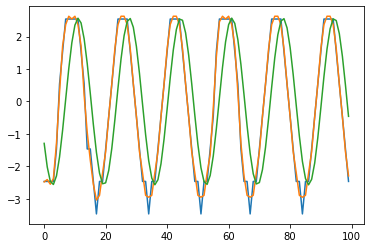

In [3]:
n_frames=100
plt.plot(transforms_zerod[:n_frames])
plt.plot(smoothed_y2[:n_frames])
plt.plot(smoothed_y[:n_frames])

### Stabilized video 

In [4]:
n_frames=100
start=timeit.default_timer()
video=cv2.VideoCapture('vid_2022-05-26_10-37-49.mp4')

ret=True
n=0
ret,frame=video.read()
while ret and n<n_frames:
    print(n,end='\r')
    dx=0
    da=0
    dy=0
    #empirically the index is off by 1 for best stabilization
    #but it doesn't make a huge difference 
    if n>0:
        dy = smoothed_y2[n-1] 

    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    frame_stabilized = cv2.warpAffine(frame, m, (frame_width,frame_height))
    cv2.imshow('video',cv2.resize(cv2.hconcat([frame,frame_stabilized]),(frame_width,frame_height//2)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
          break

    n=n+1
    ret,frame=video.read()

video.release()
cv2.destroyAllWindows()
stop=timeit.default_timer()
print(stop-start)

7.217280416000001


### Use scaled 2d KNN, previous frame surface height

In [5]:
start=timeit.default_timer()

video=cv2.VideoCapture('vid_2022-05-26_10-37-49.mp4')
history=50

#Apply one background subtractor to gray image
subtractor=cv2.createBackgroundSubtractorMOG2(history,3,False)
#Apply a second subtractor to the y derivative of gray image
subtractor2=cv2.createBackgroundSubtractorMOG2(history,20,False)

ret=True
n=0
ret,frame=video.read()
#train the subtractors
while ret and n<history:
    print(n,end='\r')
    dx=0
    da=0
    if n>0:
        dy = smoothed_y2[n-1]
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    frame_stabilized = cv2.warpAffine(frame, m, (frame_width,frame_height))
    img_gray = cv2.cvtColor(frame_stabilized,cv2.COLOR_BGR2GRAY)
    sobely = np.abs(cv2.Sobel(img_gray,cv2.CV_64F,0,2,ksize=5))
    mask=subtractor.apply(img_gray)
    mask2=subtractor2.apply(sobely)
    #blur the mask and threshold to remove outliers
    _,mask=cv2.threshold(cv2.blur(mask,(5,5)),100, 255,cv2.THRESH_BINARY)
    _,mask2=cv2.threshold(cv2.blur(mask2,(5,5)),100, 255,cv2.THRESH_BINARY)
    
    cv2.imshow('video',cv2.resize(cv2.hconcat([mask,mask2]),(frame_width,frame_height//2)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    n=n+1
    ret,frame=video.read()
stop=timeit.default_timer()
print(stop-start)

5.910846327000002


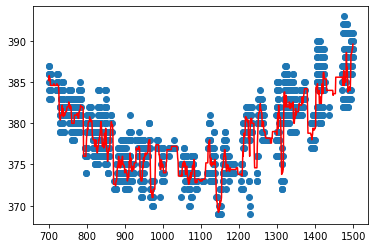

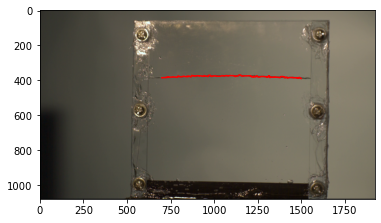

In [6]:
#initial surface guess
#do bitwise and on masks to identify point near surface
masked=cv2.bitwise_and(sobely,sobely,mask=cv2.bitwise_and(mask,mask2))
#remove points far from surface
masked[:300]=0
masked[:,:700]=0
masked[:,1500:]=0
masked[500:]=0
ret, thresh = cv2.threshold(masked, 200, 255, cv2.THRESH_BINARY)
y,x=np.where(thresh!=0)
xp=np.arange(700,1500)
#Use the x values of surface points for KNN regressor
Xp=np.zeros((len(xp),1))
regr=KNeighborsRegressor()
#Create surface by applying regressor to uniform spaced grid xp
X=x[:,np.newaxis]
Xp[:,0]=xp
regr.fit(X,y)
yp=regr.predict(Xp)
plt.scatter(x,y)
plt.plot(xp,yp,color='red')
plt.show()
plt.imshow(frame_stabilized)
plt.plot(xp,yp,color='red')
plt.show()

In [7]:
n_frames=4500

In [8]:
#Find surface for each frame and write output
#Include a scaled value of the previous height to bias KNN regressor
Xp=np.arange(700,1500)[:,np.newaxis]
yps=np.zeros((n_frames,len(Xp)))
masks=np.zeros((n_frames,frame_height,frame_width),dtype='uint8')

video=cv2.VideoCapture('vid_2022-05-26_10-37-49.mp4')
for n in range(history):
    ret,frame=video.read()
n=0

out_width=frame_width
out_height=2*frame_height//3
out = cv2.VideoWriter('out.mp4',cv2.VideoWriter_fourcc(*'X264'), 60, (out_width,out_height))

scale=1e1 #scale to weigh previous surface position in KNN
while ret and n<n_frames:
    print(n,end='\r')
    dx=0
    da=0
    dy = smoothed_y2[n-1+history]
        
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy

    frame_stabilized = cv2.warpAffine(frame, m, (frame_width,frame_height))
    img_gray = cv2.cvtColor(frame_stabilized,cv2.COLOR_BGR2GRAY)
    sobely = np.abs(cv2.Sobel(img_gray,cv2.CV_64F,0,2,ksize=5))
    
    mask=subtractor.apply(img_gray)
    mask2=subtractor2.apply(sobely)
    _,mask=cv2.threshold(cv2.blur(mask,(5,5)),100, 255,cv2.THRESH_BINARY)
    _,mask2=cv2.threshold(cv2.blur(mask2,(5,5)),100, 255,cv2.THRESH_BINARY)
    
    masked=cv2.bitwise_and(sobely,sobely,mask=cv2.bitwise_and(mask,mask2))
    masked[:300]=0
    masked[:,:700]=0
    masked[:,1500:]=0
    masked[500:]=0
    ret, thresh = cv2.threshold(masked, 200, 255, cv2.THRESH_BINARY)
    thresh=cv2.normalize(thresh, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    masks[n]=thresh
    
    #Train the regressor on [scale*x,y], x values are weighed more than y
    #This breaks ties in the KNN: multiple points can share the same x
    y,x=np.where(thresh!=0)
    X=np.array([scale*x,y]).T 
    regr=KNeighborsRegressor(weights='distance')
    regr.fit(X,y)
    #use the uniform grid with the previous surface 
    Xp=np.zeros((len(xp),X.shape[1]))
    Xp[:,0]=scale*xp
    Xp[:,1]=yp #use last yp as initial surface guess
    yp=regr.predict(Xp)
    yps[n]=yp
    yps[n+1:]=np.min(yps[:n+1])
    
    #draw a contour on the image
    line=(np.array([xp,yp],dtype='int32').T)[:,np.newaxis,:]
    newcontours=[np.concatenate([line,np.flip(line,axis=0)])]
    frame_contours=frame_stabilized.copy()
    cv2.drawContours(image=frame_contours,contours=newcontours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    
    #output
    outframe=cv2.hconcat([frame,cv2.cvtColor(thresh,cv2.COLOR_GRAY2BGR),frame_contours])
    top=cv2.resize(outframe,(out_width,out_height//2))
    bottom0=cv2.resize(cv2.normalize(yps.T,None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U),(out_width,out_height//2))
    bottom=cv2.applyColorMap(bottom0,2)
    bottom[:,int(out_width*n/n_frames):,:]=0
    outframe_full=cv2.vconcat([top,bottom])    
    out.write(cv2.resize(outframe_full,(out_width,out_height)))

    n=n+1
    ret,frame=video.read()

video.release()
out.release()
cv2.destroyAllWindows()
stop=timeit.default_timer()
print(stop-start)

OpenCV: FFMPEG: tag 0x34363258/'X264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


662.320882955


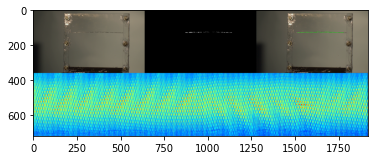

In [13]:
plt.imshow(outframe_full)

In [10]:
np.save('hvals',yps)
np.save('xvals',xp)

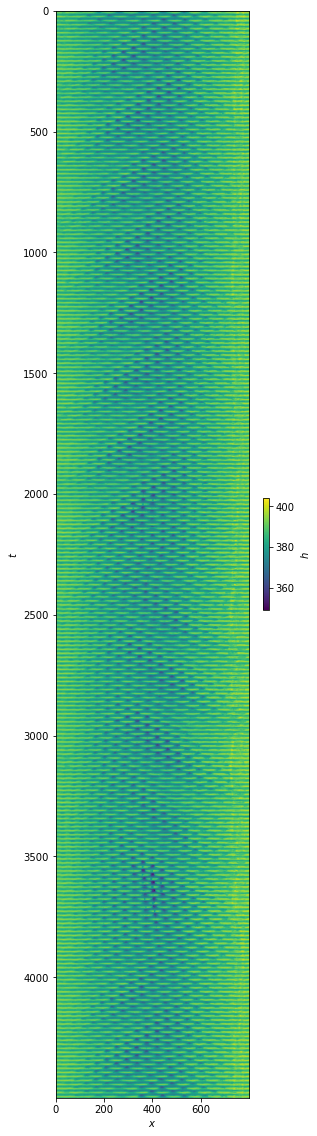

In [11]:
plt.figure(figsize=(5,20))
plt.imshow(yps)
plt.colorbar(fraction=0.02,label='$h$')
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.savefig('spacetime.pdf')
plt.show()

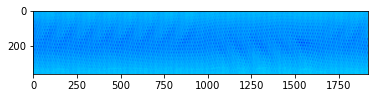

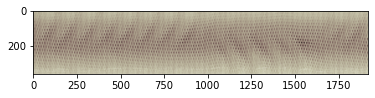

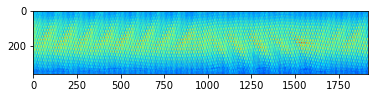

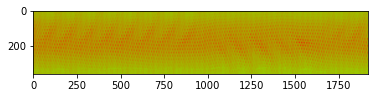

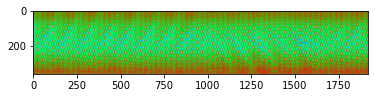

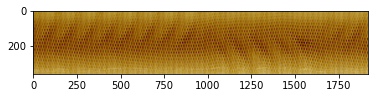

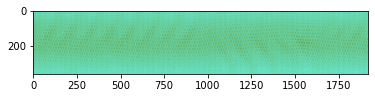

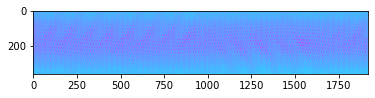

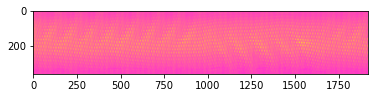

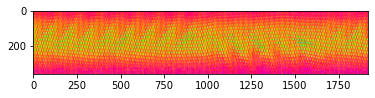

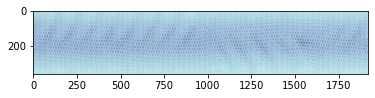

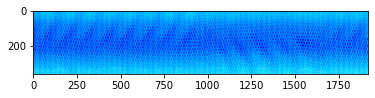

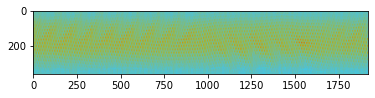

In [12]:
yps=np.load('hvals.npy')
bottom0=cv2.resize(cv2.normalize(yps.T,None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U),(out_width,out_height//2))
for i in range(13):
    plt.imshow(cv2.applyColorMap(bottom0,i))
    plt.show()